# Probabilistic Programming

## Bayesian Linear Regression

Let's use `pymc3` to estimate model parameters that predict `AirTime` from `Distance`.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from helper import *

We use the [airline on-time performance data](http://stat-computing.org/dataexpo/2009/). To ease our computation time, we limit our analysis to flights that departed from Chicago, and use every 10000th row.

In [2]:
filename = '~/2001.csv'

usecols = (13, 16, 18)
columns = ['AirTime', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'] # use only flights departed from Chicago
local = local.dropna() # drop missing values
local = local.loc[::10000] # use every 10000th row

print(local.head())

        AirTime Origin  Distance
6367         86    ORD       599
228046       97    ORD       783
409321       92    ORD       714
708982      136    ORD      1144
857277       63    ORD       296


### Linear Regression

- Function `get_trace()` will use `pymc3` to implement the following model:
$$
\begin{aligned}
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta X \\
\alpha &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(10, 1) \\
\sigma &\sim \mathcal{U}(0, 100)
\end{aligned}
$$
where $\mathcal{N}$ denotes the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) and $\mathcal{U}$ is the [uniform distribution](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous).

- Uses the names `alpha`, `beta`, and `sigma` for $\alpha$, $\beta$, and $\sigma$, respectively.
- Estimates the model paramters with the maximum a posteriori (MAP) method.
- Uses the No-U-Turn Sampler (NUTS) to generate posterior samples.

In [3]:
trace = get_trace(local.Distance.values, local.AirTime.values, n_samples=2000, random_seed=0)

Applied interval-transform to sigma and added transformed sigma_interval_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.3 sec

### Model Checking

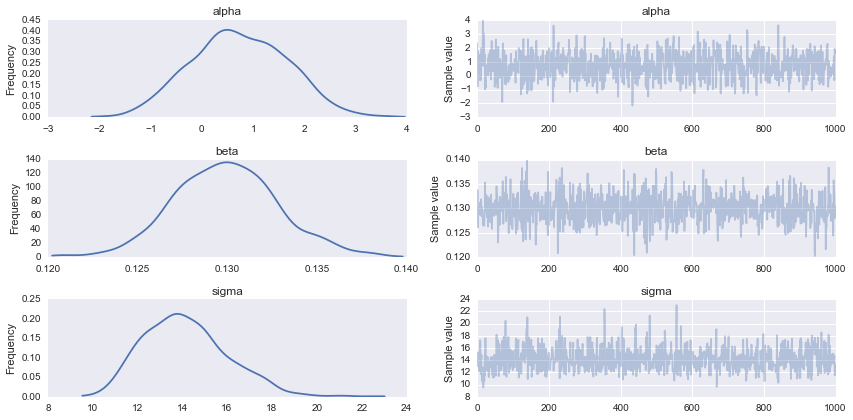

In [4]:
# Plot traces
sns.set_style('darkgrid')
pm.traceplot(trace[-1000:], ['alpha', 'beta', 'sigma'])
plt.show()

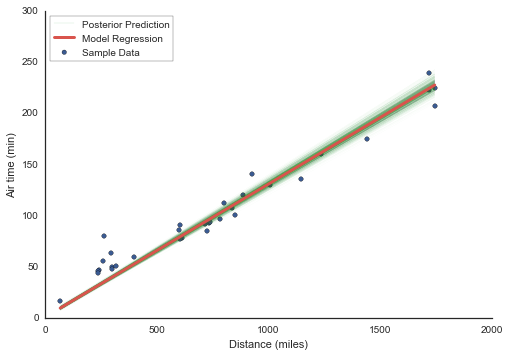

In [5]:
n_samples = 1000

x = local.Distance.values
y = local.AirTime.values

sns.set_style('white')

fig, ax = plt.subplots()

ax.scatter(x, y, c=sns.xkcd_rgb['denim blue'], label = 'Sample Data')

xl = x.min()
xh = x.max()

intercepts = trace['alpha'][-n_samples:]
slopes = trace['beta'][-n_samples:]

for m, b in zip(slopes, intercepts):
    yl = m * xl + b
    yh = m * xh + b
    ax.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['medium green'], lw=0.1, alpha = 0.1)

# Replot last one to get legend label
ax.plot((xl, xh), (yl, yh), color=sns.xkcd_rgb['medium green'], lw=0.1, label = 'Posterior Prediction')

m_fit = slopes.mean()
b_fit = intercepts.mean()

yfl = b_fit + m_fit * xl
yfh = b_fit + m_fit * xh
ax.plot((xl, xh), (yfl, yfh), color=sns.xkcd_rgb['pale red'], lw=3, label='Model Regression')

ax.set_xlim(0, 2000)
ax.set_ylim(0, 300)

ax.legend(loc='upper left', frameon=True)

ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Air time (min)')

sns.despine()

plt.show()

## Hierarchical Modeling

Now, let's implement a hierarchical model to estimate the distribution of departure delays in December of 2001.

We use the [airline on-time performance data](http://stat-computing.org/dataexpo/2009/). For simplicity, we limit our analysis to flights that departed from [CMI](https://en.wikipedia.org/wiki/University_of_Illinois_Willard_Airport) in December.

In [6]:
filename = '~/2001.csv'

usecols = (1, 2, 15, 16)
columns = ['Month', 'DayofMonth', 'DepDelay', 'Origin']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data[
    (all_data['Origin'] == 'CMI') & # use only flights departed from Chicago
    (all_data['Month'] == 12) # consider only December
    ]
local = local.drop(['Month', 'Origin'], axis=1) # we don't need Month and Origin columns
local = local.dropna() # drop missing values

print(local.head())

         DayofMonth  DepDelay
5830137           1        -8
5830138           2        38
5830139           3        -8
5830140           4         0
5830141           5        -1


We will use a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) but the Poisson distribution does not allow negative means. That is, $\mu > 0$ in

$$ Poisson(\mu) = P(x\mid\mu) = \frac{e^{-\mu}\mu^{x}}{x!}\quad\textrm{for}\, x=0,1,2,\cdots $$

However, there are some negative values in `DepDelay`.

In [7]:
print(local.DepDelay.min())

-13.0


This condition can be avoided by a simple shift in the domain, so let's add 15 minutes to all departure delays.

In [8]:
def shift_column(df, field, shift):
    return pd.concat([df.drop(field, axis=1), df[field].apply(lambda x: x + shift)], axis=1) 

local_shifted = shift_column(local, 'DepDelay', 15)

print(local_shifted.head())

         DayofMonth  DepDelay
5830137           1         7
5830138           2        53
5830139           3         7
5830140           4        15
5830141           5        14


For simplicity, let's remove some outliers and only consider departure delays less than 60 minutes.

In [9]:
local_shifted = local_shifted[local_shifted['DepDelay'] < 60]

In the following section, we model each day independently, modeling paramters $\mu_i$ of the Poisson distribution for each day of December, $i=1, 2, \cdots, 31$. The reasoning behind this is that the departure delays will depend on different conditions of each day, e.g. the weather, whether it's a weekend or a weekday, whehter it's a holiday, etc.

Simiarly to the use of `county_idx` [here](http://pymc-devs.github.io/pymc3/GLM-hierarchical/), we need a way to map `mu` (an array of length 31) to an array that has the length as `local_shifted`.

We can use the `DayofMonth` column to create `date_idx`:

In [10]:
date_idx = local_shifted['DayofMonth'].values - 1
print(date_idx)

[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 17 18 19 21 22 23 24 25 26 27
 28 29 30  0  1  2  3  4  5  6  7  8 10 12 14 16 17 18 20 25 26 28 29 30  0
  1  3  4  5  6  7  8  9 10 12 14 15 16 18 20 21 22 24 26 27 28 29 30  2  3
  4  5  6  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 27 28 29 30  0
  2  3  4  8  9 10 11 13 15 17 18 19 20 21 22 23 24 25 26 27 29]


And we can use `date_idx` as follows:

```python
>>> mu = np.arange(31)
>>> print(mu)
```
```
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
```
```python
>>> print(mu[date_idx])
```
```
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 17 18 19 21 22 23 24 25 26 27
 28 29 30  0  1  2  3  4  5  6  7  8 10 12 14 16 17 18 20 25 26 28 29 30  0
  1  3  4  5  6  7  8  9 10 12 14 15 16 18 20 21 22 24 26 27 28 29 30  2  3
  4  5  6  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 27 28 29 30  0
  2  3  4  8  9 10 11 13 15 17 18 19 20 21 22 23 24 25 26 27 29]
```
```python
>>> len(mu[date_idx]) == len(local_shifted)
```
```
True
```

### Hierarchical Model

- Function `poisson_posterior()` uses `pymc3` to implement the following hierarchical model:
$$
\begin{aligned}
y_{ji} &\sim Poisson(\mu_{i}) \\
\mu_i &= Gamma(\alpha_\mu, \beta_\mu) \\
\alpha_\mu &= Gamma(1, 1) \\
\beta_\mu &= Gamma(1, 1)
\end{aligned}
$$
for each flight $j$ and each day $i$.

Note there are two ways to specify a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution): either in terms of alpha and beta or mean and standard deviation. In this problem, we parametrize it in terms of alpha (the shape parameter) and beta (the rate parameter).

- Uses the names `mu`, `hyper_alpha_mu`, and `hyper_beta_mu` for $\mu_i$, $\alpha_\mu$, and $\beta_\mu$, respectively.
- Estimates the model paramters with the maximum a posteriori (MAP) method.
- Uses the `Metropolis` sampler to generate posterior samples.

In [11]:
hierarchical_trace = poisson_posterior(X=local_shifted['DepDelay'].values, idx=date_idx, n_samples=80000, random_seed=0)

Applied log-transform to hyper_alpha_mu and added transformed hyper_alpha_mu_log_ to model.
Applied log-transform to hyper_beta_mu and added transformed hyper_beta_mu_log_ to model.
Applied log-transform to mu and added transformed mu_log_ to model.
 [-----------------100%-----------------] 80000 of 80000 complete in 38.1 sec

### Model Checking

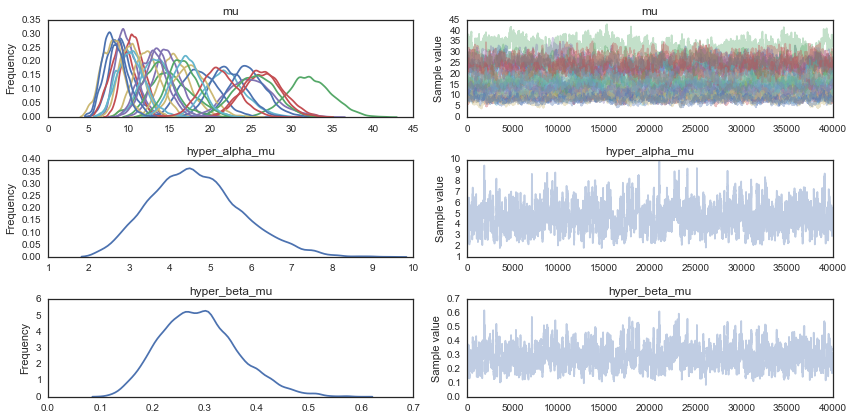

In [12]:
pm.traceplot(hierarchical_trace[40000:], varnames=['mu', 'hyper_alpha_mu', 'hyper_beta_mu']);

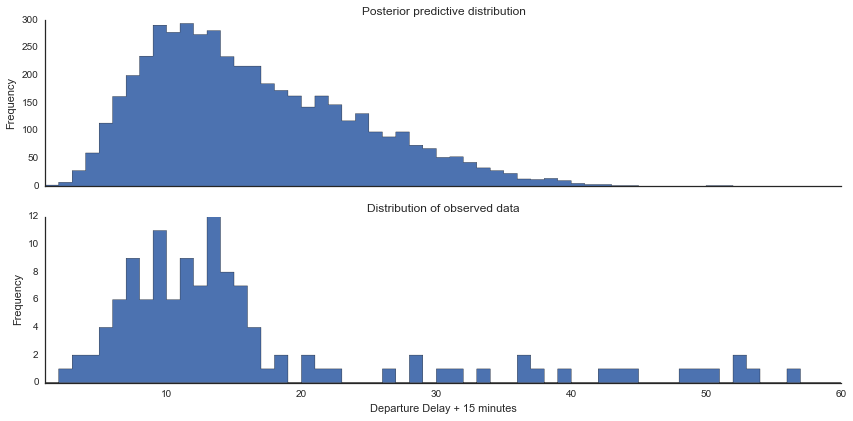

In [13]:
x_lim = 60
n_burn = 40000

# we discard burn-in and use every 1000th trace
y_pred = hierarchical_trace.get_values('y_pred')[n_burn::1000].ravel()

sns.set_style('white')
fig, ax = plt.subplots(2, sharex=True, figsize=(12,6))

ax[0].hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled')   
ax[0].set_xlim(1, x_lim)
ax[0].set_ylabel('Frequency')
ax[0].set_title('Posterior predictive distribution')

ax[1].hist(local_shifted.DepDelay.values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
ax[1].set_xlabel('Departure Delay + 15 minutes')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of observed data')

sns.despine()

plt.tight_layout()

plt.show()

## General Linear Models

Let's use a general linear model to fit a linear model that predicts `AirTime` from `Distance`.

We use the [airline on-time performance data](http://stat-computing.org/dataexpo/2009/). For simplicity, we limit our analysis to flights that departed from Chicago, and use every 10000th row.

In [14]:
filename = '~/2001.csv'

usecols = (13, 16, 18)
columns = ['AirTime', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'] # use only flights departed from Chicago
local = local.dropna() # drop missing values
local = local.loc[::10000] # use every 10000th row

print(local.head())

        AirTime Origin  Distance
6367         86    ORD       599
228046       97    ORD       783
409321       92    ORD       714
708982      136    ORD      1144
857277       63    ORD       296


### General Linear Model

- We estimate a Bayesian linear regression model using the `pymc3.glm.glm()` function.
- We can sssume that our data is distributed according to the [Student's *t*-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).
- We will use a [Patsy](https://patsy.readthedocs.org/en/latest/formulas.html) string to describe the linear model, naming the independent variable `x` and the dependent variable `y`.
- The function `linear_posterior()` estimate the model paramters with the maximum a posteriori (MAP) method (using default paramters).
- Uses the No-U-Turn Sampler (NUTS) to generate posterior samples.

In [15]:
trace = linear_posterior(local.Distance.values, local.AirTime.values, n_samples=2000, random_seed=0)

Applied log-transform to lam and added transformed lam_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.9 sec

### Model Checking

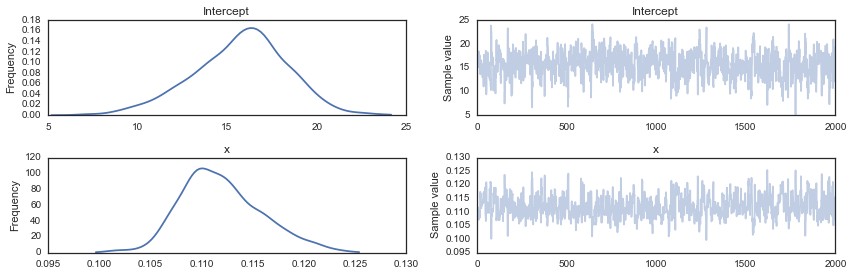

In [16]:
pm.traceplot(trace, ['Intercept', 'x']);

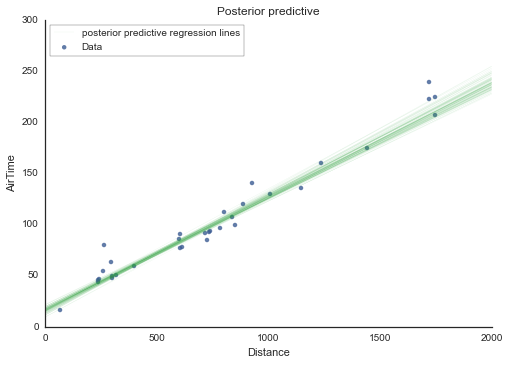

In [17]:
sns.set(style='white')

ax = sns.regplot(data=local, x='Distance', y='AirTime',
                 fit_reg=False, color=sns.xkcd_rgb["denim blue"], label="Data")

ax.set_xlim(0, 2000)
ax.set_ylim(0, 300)

x_sample = np.linspace(0, 2000, 2)

pm.glm.plot_posterior_predictive(trace[:1500], samples=100, eval=x_sample,
                                 label='posterior predictive regression lines', color=sns.xkcd_rgb["medium green"], alpha=0.2)
sns.despine()

ax.legend(loc='upper left', frameon=True)

plt.show()